# Stress Detection Models 

In this notebook we are going to be testing three approaches for stress detection using biosignals like Heart Rate and/or Heart Rate Variability for each one of the following datasets:

1. [Nurse Stress Prediction Wearable Sensors](https://www.kaggle.com/datasets/priyankraval/nurse-stress-prediction-wearable-sensors)
2. [Heart Rate Prediction to Monitor Stress Level](https://www.kaggle.com/datasets/vinayakshanawad/heart-rate-prediction-to-monitor-stress-level)
3. [Stress-Predict-Dataset](https://github.com/italha-d/Stress-Predict-Dataset)
4. [SWELL dataset](https://www.kaggle.com/datasets/qiriro/swell-heart-rate-variability-hrv)




In [1]:
# Import libraries
import os, warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from keras import Input

warnings.filterwarnings('always')
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Import Data Paths
data_path = os.getcwd() + '/data' 

---

# Nurse Stress Prediction Wearable Sensors

In [2]:
# Load the dataset
data = pd.read_csv(data_path + '/Healthcare/hrv.csv')
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 332295 entries, 0 to 332294
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   HR        332295 non-null  float64
 1   HRV       332295 non-null  float64
 2   datetime  332295 non-null  object 
 3   label     332295 non-null  int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 12.7+ MB


## Threshold-Based Rule Engine Approach

+ Pros:
    - Easy to understand and deploy
    - No training needed

- Cons:
    - May be inaccurate
    - Doesn’t adapt to individual differences

In [3]:
def classify_stress_threshold(hrv: float, hr: float) -> str:
    if hrv < 40 and hr > 70:
        return 'high'
    elif hrv < 50 and hr > 60:
        return 'medium'
    else:
        return 'low'

In [4]:
# Get the predictions of the rule-based model and encode the labels to get the accuracy of this approach
data['stress_pred_rule'] = data.apply(lambda row: classify_stress_threshold(row['HRV'], row['HR']), axis=1)
labels = data['label'].apply(lambda x: 'high' if x == 2 else ('medium' if x == 1 else 'low'))
labels_predictions = data['stress_pred_rule']

print('Threshold-Based Rule Accuracy:', accuracy_score(labels, labels_predictions))
print('The classification report matrix of the threshold-based rule is:\n', classification_report(labels, labels_predictions, zero_division=0))

Threshold-Based Rule Accuracy: 0.6681984381347899
The classification report matrix of the threshold-based rule is:
               precision    recall  f1-score   support

        high       0.73      0.89      0.81    246086
         low       0.03      0.00      0.01     61359
      medium       0.08      0.07      0.08     24850

    accuracy                           0.67    332295
   macro avg       0.28      0.32      0.30    332295
weighted avg       0.55      0.67      0.60    332295



## Unsupervised Learning Approach (Clustering)

- Pros:
    - No labels needed
    - Can reveal natural structure

- Cons:
    - Clusters may not match stress labels
    - Hard to evaluate accuracy directly

Kmeans Accuracy: 0.40878737266585413
The classification report matrix of the Kmeans model is:
               precision    recall  f1-score   support

        high       0.73      0.44      0.55    246086
         low       0.16      0.37      0.23     61359
      medium       0.09      0.15      0.11     24850

    accuracy                           0.41    332295
   macro avg       0.33      0.32      0.30    332295
weighted avg       0.58      0.41      0.46    332295



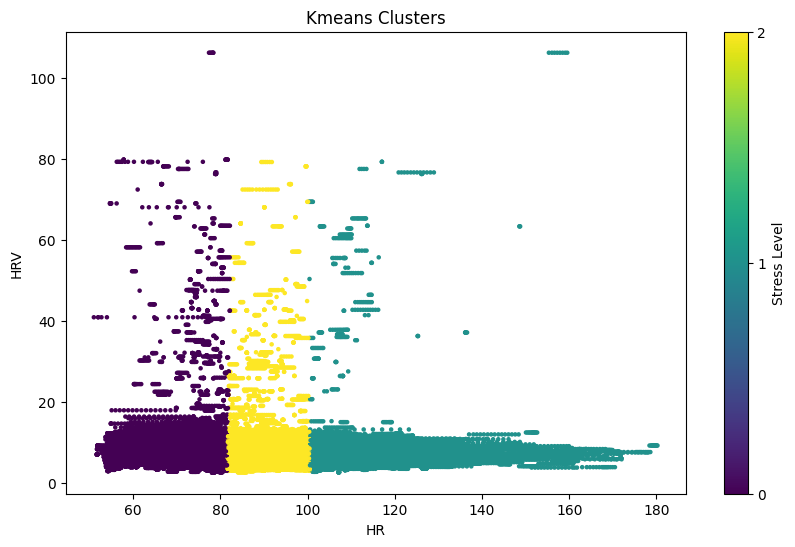

In [5]:
# Create Kmeans model with 3 clusters for the 3 classes [low, medium, high]
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data[['HRV', 'HR']])
data['stress_pred_kmeans'] = kmeans.predict(data[['HRV', 'HR']])

# Map the cluster labels to the stress levels
cluster_mapping = {0: 'low', 1: 'medium', 2: 'high'}
data['stress_pred_kmeans'] = data['stress_pred_kmeans'].map(cluster_mapping)

# Get the predictions of the Kmeans model and encode the labels to get the accuracy of this approach
labels_predictions = data['stress_pred_kmeans']
print('Kmeans Accuracy:', accuracy_score(labels, labels_predictions))
print('The classification report matrix of the Kmeans model is:\n', classification_report(labels, labels_predictions, zero_division=0))


# Plot the clusters
plt.figure(figsize=(10, 6))
plt.title('Kmeans Clusters')
plt.scatter(data['HR'], data['HRV'], c=data['stress_pred_kmeans'].map({'low': 0, 'medium': 1, 'high': 2}), s=5)
plt.xlabel('HR')
plt.ylabel('HRV')
plt.colorbar(ticks=[0, 1, 2], label='Stress Level')
plt.show()

## Machine Learning Approach (Random Forest)

- Pros:
    - Learns patterns from data
    - Easy to extend with more features

- Cons:
    - Requires labeled data
    - Risk of overfitting on small or biased data

In [6]:
# Get the features and labels for the Random Forest Classifier
X = data[['HR', 'HRV']]
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Create the Random Forest Classifier model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Get the predictions of the Random Forest Classifier
data['stress_pred_rf'] = clf.predict(X)
data['stress_pred_rf'] = data['stress_pred_rf'].map({0: 'low', 1: 'medium', 2: 'high'})
labels_predictions = data['stress_pred_rf']


print('The classification report matrix of the train data for the Random Forest Classifier is:\n', classification_report(labels, labels_predictions, zero_division=0))

The classification report matrix of the train data for the Random Forest Classifier is:
               precision    recall  f1-score   support

        high       0.94      0.97      0.95    246086
         low       0.88      0.80      0.84     61359
      medium       0.90      0.78      0.83     24850

    accuracy                           0.92    332295
   macro avg       0.90      0.85      0.87    332295
weighted avg       0.92      0.92      0.92    332295



In [7]:
# Get the predictions of the Random Forest Classifier and encode the labels to get the accuracy of this approach
y_pred = clf.predict(X_test)

# Encode the labels to present the accuracy of this approach for the test data
y_test = y_test.map({0: 'low', 1: 'medium', 2: 'high'})
y_pred = pd.Series(y_pred).map({0: 'low', 1: 'medium', 2: 'high'})

print('The classification report matrix of the test data for the Random Forest Classifier is:\n', classification_report(y_test, y_pred))

The classification report matrix of the test data for the Random Forest Classifier is:
               precision    recall  f1-score   support

        high       0.82      0.90      0.86     61522
         low       0.53      0.39      0.44     15340
      medium       0.52      0.32      0.40      6212

    accuracy                           0.76     83074
   macro avg       0.62      0.54      0.57     83074
weighted avg       0.74      0.76      0.75     83074



## Deep Learning Approach

In [8]:
# Feature Engineering and Scaling
features = data[['HR', 'HRV']]
labels = data['label'].astype('int32')

# Create the train/test split
features_train, features_test, labels_train, labels_test= train_test_split(features, labels, test_size=0.2,random_state=34)

In [9]:
# Create callback function for early stopping in case we have a decrease in accuracy
callback = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=True, mode='auto', baseline=None, restore_best_weights=True)

# Create the Deep Learning Model Architecture
model = Sequential()
model.add(Input(shape=(features_train.shape[1],)))
model.add(Dense(features_train.shape[1], activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(3,activation='softmax'))

# Compilation of the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

2025-05-27 14:36:41.642231: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-05-27 14:36:41.642415: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-05-27 14:36:41.642429: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-05-27 14:36:41.642652: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-27 14:36:41.642668: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85 (340.00 B)

 Trainable params: 85 (340.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the model
history=model.fit(features_train, labels_train, validation_split=0.1, epochs=10, verbose=True, batch_size=512, callbacks=callback)

Epoch 1/10


2025-05-27 14:36:42.149244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


468/468 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.3686 - loss: 27.4901 - val_accuracy: 0.7423 - val_loss: 0.7330
Epoch 2/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7415 - loss: 0.7354 - val_accuracy: 0.7423 - val_loss: 0.7347
Epoch 3/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7389 - loss: 0.7378 - val_accuracy: 0.7423 - val_loss: 0.7332
Epoch 4/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7402 - loss: 0.7364 - val_accuracy: 0.7423 - val_loss: 0.7327
Epoch 5/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7421 - loss: 0.7331 - val_accuracy: 0.7423 - val_loss: 0.7317
Epoch 6/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7405 - loss: 0.7351 - val_accuracy: 0.7423 - val_loss: 0.7382
Epoch 7/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7394 - loss: 0.7374 - val_accuracy: 0.7423 - val_loss: 0.7356
Epoch 8/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7415 - loss: 0.7330 - val_accuracy: 0.7423 - val

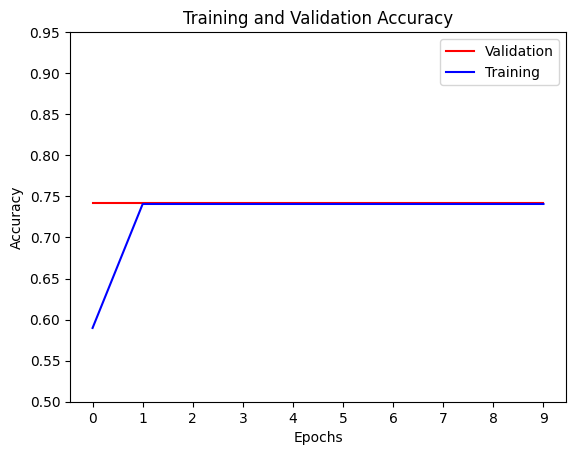

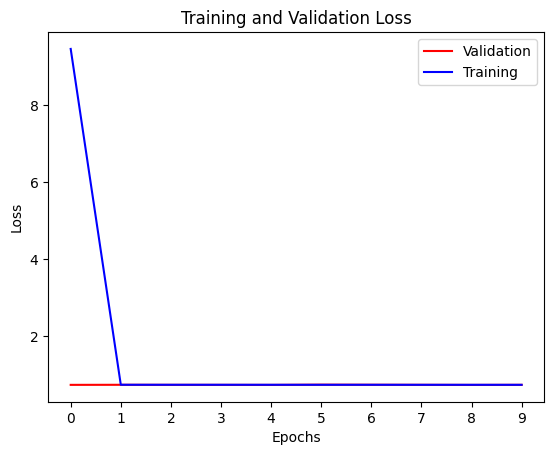

In [11]:
#Traininng Visualization
plt.plot(history.history['val_accuracy'],color='red',label='Validation')
plt.plot(history.history['accuracy'],color='blue',label='Training')
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.arange(0.5, 1, 0.05))
plt.xlabel('Epochs')    
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


#Traininng Visualization
plt.plot(history.history['val_loss'],color='red',label='Validation')
plt.plot(history.history['loss'],color='blue',label='Training')
plt.xticks(np.arange(0, 10, 1))
plt.xlabel('Epochs')    
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [12]:
# Performance on Testing Data
# Evaluate the model on test data
loss, accuracy = model.evaluate(features_test, labels_test)

2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7377 - loss: 0.7406


---

# Heart Rate Prediction to Monitor Stress Level

In [13]:
# Load the training dataset
train_data = pd.read_csv(data_path + '/Heart_Rate_Prediction/Train_Data/train.csv')
train_data = train_data.rename(columns={'RMSSD': 'HRV'})
train_data.dropna(inplace=True)

# Map the stress levels to the labels [high, medium, low]
train_data['condition'] = train_data['condition'].map({'no stress': 'low', 'interruption': 'medium', 'time pressure': 'high'})
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 332307 entries, 0 to 332306
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   uuid       332307 non-null  object 
 1   condition  332307 non-null  object 
 2   HRV        332307 non-null  float64
 3   HR         332307 non-null  float64
dtypes: float64(2), object(2)
memory usage: 12.7+ MB


## Threshold-Based Rule Engine Approach

In [14]:
# Get the predictions of the rule-based model and encode the labels to get the accuracy of this approach
train_data['stress_pred_rule'] = train_data.apply(lambda row: classify_stress_threshold(row['HRV'], row['HR']), axis=1)
labels = train_data['condition']
labels_predictions = train_data['stress_pred_rule']


print('Threshold-Based Rule Accuracy:', accuracy_score(labels, labels_predictions))
print('The classification report matrix of the threshold-based rule is:\n', classification_report(labels, labels_predictions, zero_division=0))

Threshold-Based Rule Accuracy: 0.193345310210137
The classification report matrix of the threshold-based rule is:
               precision    recall  f1-score   support

        high       0.17      0.89      0.29     57650
         low       0.56      0.03      0.05    180131
      medium       0.29      0.08      0.13     94526

    accuracy                           0.19    332307
   macro avg       0.34      0.33      0.16    332307
weighted avg       0.41      0.19      0.12    332307



## Unsupervised Learning Approach (Clustering)

Kmeans Accuracy: 0.37001327086098096
The classification report matrix of the Kmeans model is:
               precision    recall  f1-score   support

        high       0.17      0.36      0.24     57650
         low       0.54      0.49      0.51    180131
      medium       0.28      0.15      0.19     94526

    accuracy                           0.37    332307
   macro avg       0.33      0.33      0.31    332307
weighted avg       0.40      0.37      0.37    332307



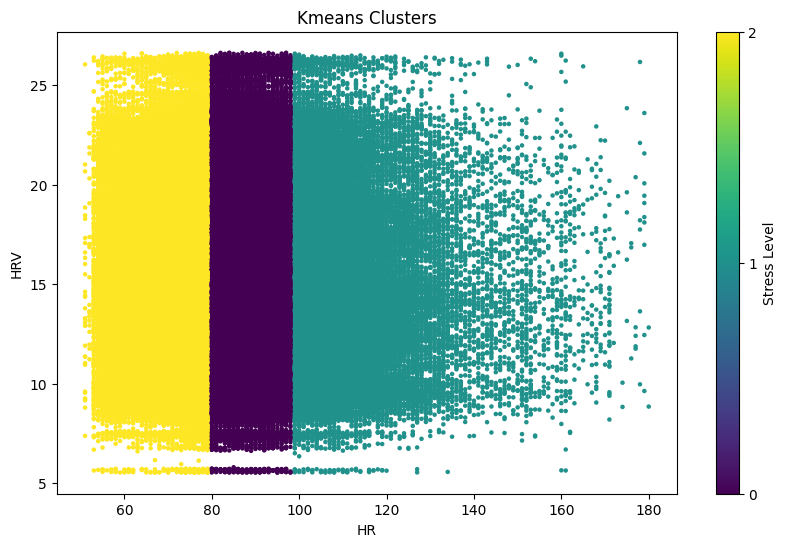

In [15]:
# Create Kmeans model with 3 clusters for the 3 classes [low, medium, high]
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(train_data[['HRV', 'HR']])
train_data['stress_pred_kmeans'] = kmeans.predict(train_data[['HRV', 'HR']])

# Map the cluster labels to the stress levels
cluster_mapping = {0: 'low', 1: 'medium', 2: 'high'}
train_data['stress_pred_kmeans'] = train_data['stress_pred_kmeans'].map(cluster_mapping)

# Get the predictions of the Kmeans model and encode the labels to get the accuracy of this approach
labels_predictions = train_data['stress_pred_kmeans']

print('Kmeans Accuracy:', accuracy_score(labels, labels_predictions))
print('The classification report matrix of the Kmeans model is:\n', classification_report(labels, labels_predictions, zero_division=0))


# Plot the clusters
plt.figure(figsize=(10, 6))
plt.title('Kmeans Clusters')
plt.scatter(train_data['HR'], train_data['HRV'], c=train_data['stress_pred_kmeans'].map({'low': 0, 'medium': 1, 'high': 2}), s=5)
plt.xlabel('HR')
plt.ylabel('HRV')
plt.colorbar(ticks=[0, 1, 2], label='Stress Level')
plt.show()

## Machine Learning Approach (Random Forest)

In [16]:
# Get the features and labels for the Random Forest Classifier
X = train_data[['HR', 'HRV']]
y = train_data['condition']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Create the Random Forest Classifier model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Get the predictions of the Random Forest Classifier
train_data['stress_pred_rf'] = clf.predict(X)
labels_predictions = train_data['stress_pred_rf']

print('The classification report matrix of the train data for the Random Forest Classifier is:\n', classification_report(labels, labels_predictions, zero_division=0))

The classification report matrix of the train data for the Random Forest Classifier is:
               precision    recall  f1-score   support

        high       0.82      0.81      0.81     57650
         low       0.90      0.90      0.90    180131
      medium       0.85      0.84      0.85     94526

    accuracy                           0.87    332307
   macro avg       0.85      0.85      0.85    332307
weighted avg       0.87      0.87      0.87    332307



## Deep Learning Approach

In [17]:
# Feature Engineering and Scaling
num_classes = 3
features = train_data[['HR', 'HRV']]
labels   = train_data['condition'].map({'low': 0, 'medium': 1, 'high': 2})
labels = to_categorical(labels, num_classes=num_classes)

# Create the train/test split
features_train, features_test, labels_train, labels_test= train_test_split(features, labels, test_size=0.2,random_state=34)

In [18]:
# Create callback function for early stopping in case we have a decrease in accuracy
callback = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=True, mode='auto', baseline=None, restore_best_weights=True)

# Define a small learning rate for the optimizer
optimizer = keras.optimizers.Adam(0.001)


# Create the Deep Learning Model Architecture
model = Sequential()
model.add(Input(shape=(features_train.shape[1],)))
model.add(Dense(features_train.shape[1], activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(3,activation='softmax'))

# Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85 (340.00 B)

 Trainable params: 85 (340.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Train the model
history=model.fit(features_train, labels_train, validation_split=0.1, epochs=10, verbose=True, batch_size=256, callbacks=callback)

Epoch 1/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.4071 - loss: 6.4626 - val_accuracy: 0.5421 - val_loss: 0.9979
Epoch 2/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.5510 - loss: 0.9860 - val_accuracy: 0.5508 - val_loss: 0.9941
Epoch 3/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.5595 - loss: 0.9795 - val_accuracy: 0.5598 - val_loss: 0.9737
Epoch 4/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.5599 - loss: 0.9773 - val_accuracy: 0.5643 - val_loss: 0.9716
Epoch 5/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.5609 - loss: 0.9756 - val_accuracy: 0.5630 - val_loss: 0.9712
Epoch 6/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.5601 - loss: 0.9764 - val_accuracy: 0.5484 - val_loss: 0.9774
Epoch 7/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.5631 - loss: 0.9734 - val_accuracy: 0.5582 - val_loss: 0.9769
Epoch 8/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.5623 - loss: 0.9744 - 

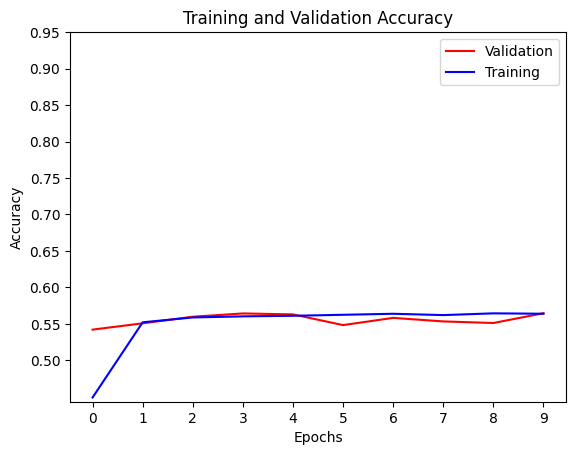

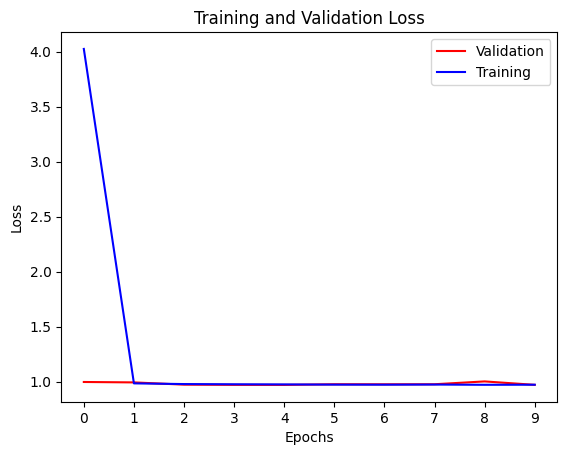

In [20]:
#Training Visualization
plt.plot(history.history['val_accuracy'],color='red',label='Validation')
plt.plot(history.history['accuracy'],color='blue',label='Training')
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.arange(0.5, 1, 0.05))
plt.xlabel('Epochs')    
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['val_loss'],color='red',label='Validation')
plt.plot(history.history['loss'],color='blue',label='Training')
plt.xticks(np.arange(0, 10, 1))
plt.xlabel('Epochs')    
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

---

# Stress Predict 

In [21]:
# Load the dataset
data = pd.read_csv(data_path + '/Stress_predict/hrv.csv')
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112471 entries, 0 to 112514
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Participant  112471 non-null  int64  
 1   HR           112471 non-null  float64
 2   HRV          112471 non-null  float64
 3   Label        112471 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 4.3 MB


## Threshold-Based Rule Engine Approach

In [22]:
# Get the predictions of the rule-based model and encode the labels to get the accuracy of this approach
data['stress_pred_rule'] = data.apply(lambda row: classify_stress_threshold(row['HRV'], row['HR']), axis=1)
labels = data['Label'].map({0: 'low', 1: 'high'})
labels_predictions = data['stress_pred_rule']


print('Threshold-Based Rule Accuracy:', accuracy_score(labels, labels_predictions))
print('The classification report matrix of the threshold-based rule is:\n', classification_report(labels, labels_predictions, zero_division=0))

Threshold-Based Rule Accuracy: 0.3026735780779045
The classification report matrix of the threshold-based rule is:
               precision    recall  f1-score   support

        high       0.36      0.87      0.51     36815
         low       0.73      0.03      0.05     75656
      medium       0.00      0.00      0.00         0

    accuracy                           0.30    112471
   macro avg       0.36      0.30      0.19    112471
weighted avg       0.61      0.30      0.20    112471



## Unsupervised Learning Approach (Clustering)

Kmeans Accuracy: 0.3014288127606227
The classification report matrix of the Kmeans model is:
               precision    recall  f1-score   support

        high       0.42      0.17      0.24     36815
         low       0.64      0.36      0.46     75656
      medium       0.00      0.00      0.00         0

    accuracy                           0.30    112471
   macro avg       0.35      0.18      0.24    112471
weighted avg       0.57      0.30      0.39    112471



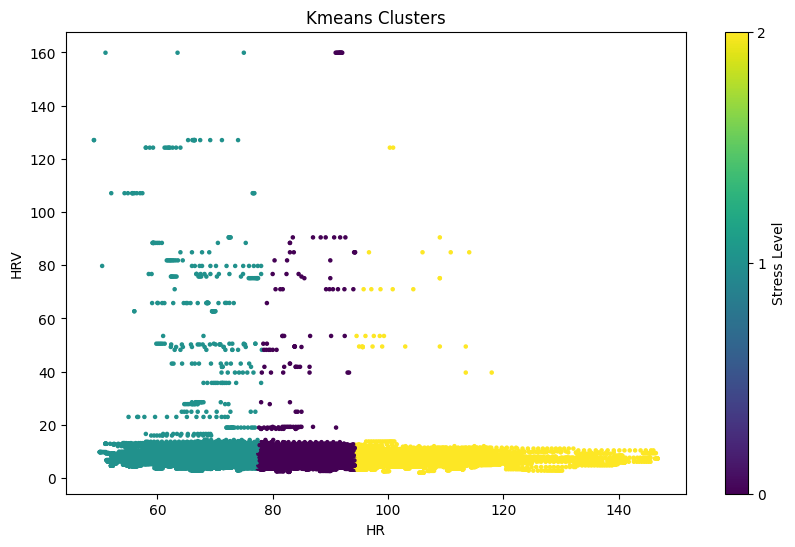

In [23]:
# Create Kmeans model with 3 clusters for the 3 classes [low, medium, high]
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data[['HRV', 'HR']])
data['stress_pred_kmeans'] = kmeans.predict(data[['HRV', 'HR']])

# Map the cluster labels to the stress levels
cluster_mapping = {0: 'low', 1: 'medium', 2: 'high'}
data['stress_pred_kmeans'] = data['stress_pred_kmeans'].map(cluster_mapping)

# Get the predictions of the Kmeans model and encode the labels to get the accuracy of this approach
labels_predictions = data['stress_pred_kmeans']

print('Kmeans Accuracy:', accuracy_score(labels, labels_predictions))
print('The classification report matrix of the Kmeans model is:\n', classification_report(labels, labels_predictions, zero_division=0))


# Plot the clusters
plt.figure(figsize=(10, 6))
plt.title('Kmeans Clusters')
plt.scatter(data['HR'], data['HRV'], c=data['stress_pred_kmeans'].map({'low': 0, 'medium': 1, 'high': 2}), s=5)
plt.xlabel('HR')
plt.ylabel('HRV')
plt.colorbar(ticks=[0, 1, 2], label='Stress Level')
plt.show()

## Machine Learning Approach (Random Forest)

In [24]:
# Get the features and labels for the Random Forest Classifier
X = data[['HR', 'HRV']]
y = data['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Create the Random Forest Classifier model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Get the predictions of the Random Forest Classifier
data['stress_pred_rf'] = clf.predict(X)
labels_predictions = data['stress_pred_rf'].map({0: 'low', 1: 'high'})

print('The classification report matrix of the train data for the Random Forest Classifier is:\n', classification_report(labels, labels_predictions, zero_division=0))

The classification report matrix of the train data for the Random Forest Classifier is:
               precision    recall  f1-score   support

        high       0.93      0.90      0.92     36815
         low       0.95      0.97      0.96     75656

    accuracy                           0.95    112471
   macro avg       0.94      0.93      0.94    112471
weighted avg       0.95      0.95      0.95    112471



## Deep Learning Approach

In [25]:
# Feature Engineering and Scaling
num_classes = 2
features = data[['HR', 'HRV']]
labels   = data['Label']

# Create the train/test split
features_train, features_test, labels_train, labels_test= train_test_split(features, labels, test_size=0.2,random_state=34)

In [26]:
# Create callback function for early stopping in case we have a decrease in accuracy
callback = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=True, mode='auto', baseline=None, restore_best_weights=True)

# Define a small learning rate for the optimizer
optimizer = keras.optimizers.Adam(0.001)


# Create the Deep Learning Model Architecture
model = Sequential()
model.add(Input(shape=(features_train.shape[1],)))
model.add(Dense(features_train.shape[1], activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(3,activation='softmax'))

# Compilation of the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85 (340.00 B)

 Trainable params: 85 (340.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Train the model
history=model.fit(features_train, labels_train, validation_split=0.1, epochs=10, verbose=True, batch_size=256, callbacks=callback)

Epoch 1/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5516 - loss: 3.7018 - val_accuracy: 0.6727 - val_loss: 0.6349
Epoch 2/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6703 - loss: 0.6353 - val_accuracy: 0.6729 - val_loss: 0.6349
Epoch 3/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6711 - loss: 0.6358 - val_accuracy: 0.6727 - val_loss: 0.6328
Epoch 4/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6732 - loss: 0.6333 - val_accuracy: 0.6727 - val_loss: 0.6319
Epoch 5/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6736 - loss: 0.6335 - val_accuracy: 0.6721 - val_loss: 0.6348
Epoch 6/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6702 - loss: 0.6351 - val_accuracy: 0.6727 - val_loss: 0.6307
Epoch 7/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6713 - loss: 0.6326 - val_accuracy: 0.6727 - val_loss: 0.6387
Epoch 8/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6727 - loss: 0.6331 - val_accuracy: 0

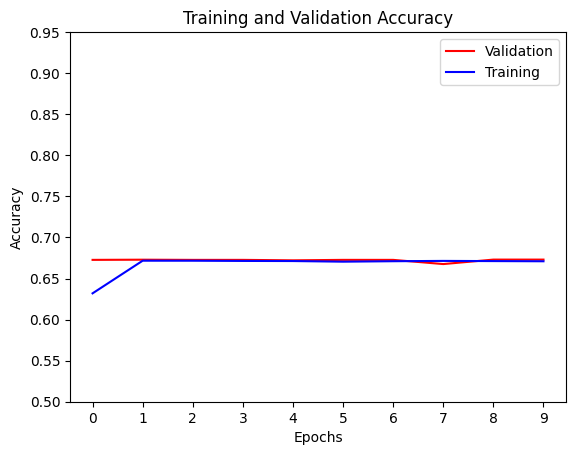

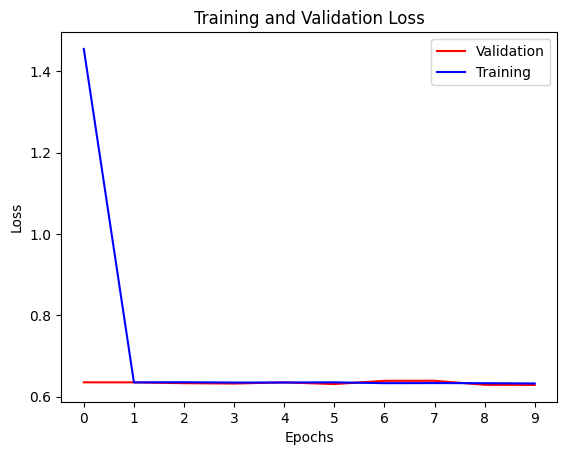

In [28]:
#Training Visualization
plt.plot(history.history['val_accuracy'],color='red',label='Validation')
plt.plot(history.history['accuracy'],color='blue',label='Training')
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.arange(0.5, 1, 0.05))
plt.xlabel('Epochs')    
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['val_loss'],color='red',label='Validation')
plt.plot(history.history['loss'],color='blue',label='Training')
plt.xticks(np.arange(0, 10, 1))
plt.xlabel('Epochs')    
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

---

# SWELL Dataset

In [29]:
# Load the dataset
data = pd.read_csv(data_path + '/SWELL/train.csv')
data['RMSSD'] = data['RMSSD'].astype(int)
data['HR'] = data['HR'].astype(int)
data['condition'] = data['condition'].map({'no stress': 'low', 'interruption': 'medium', 'time pressure': 'high'})
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369289 entries, 0 to 369288
Data columns (total 36 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   MEAN_RR            369289 non-null  float64
 1   MEDIAN_RR          369289 non-null  float64
 2   SDRR               369289 non-null  float64
 3   RMSSD              369289 non-null  int64  
 4   SDSD               369289 non-null  float64
 5   SDRR_RMSSD         369289 non-null  float64
 6   HR                 369289 non-null  int64  
 7   pNN25              369289 non-null  float64
 8   pNN50              369289 non-null  float64
 9   SD1                369289 non-null  float64
 10  SD2                369289 non-null  float64
 11  KURT               369289 non-null  float64
 12  SKEW               369289 non-null  float64
 13  MEAN_REL_RR        369289 non-null  float64
 14  MEDIAN_REL_RR      369289 non-null  float64
 15  SDRR_REL_RR        369289 non-null  float64
 16  RM

## Threshold-Based Rule Engine Approach

In [30]:
# Get the predictions of the rule-based model and encode the labels to get the accuracy of this approach
data['stress_pred_rule'] = data.apply(lambda row: classify_stress_threshold(row['RMSSD'], row['HR']), axis=1)
labels = data['condition']
labels_predictions = data['stress_pred_rule']


print('Threshold-Based Rule Accuracy:', accuracy_score(labels, labels_predictions))
print('The classification report matrix of the threshold-based rule is:\n', classification_report(labels, labels_predictions, zero_division=0))

Threshold-Based Rule Accuracy: 0.1479627067147952
The classification report matrix of the threshold-based rule is:
               precision    recall  f1-score   support

        high       0.09      0.31      0.14     64057
         low       0.26      0.05      0.08    200082
      medium       0.23      0.24      0.23    105150

    accuracy                           0.15    369289
   macro avg       0.19      0.20      0.15    369289
weighted avg       0.22      0.15      0.14    369289



## Unsupervised Learning Approach (Clustering)

Kmeans Accuracy: 0.21906961756239693
The classification report matrix of the Kmeans model is:
               precision    recall  f1-score   support

        high       0.10      0.29      0.15     64057
         low       0.41      0.28      0.33    200082
      medium       0.13      0.06      0.09    105150

    accuracy                           0.22    369289
   macro avg       0.21      0.21      0.19    369289
weighted avg       0.28      0.22      0.23    369289



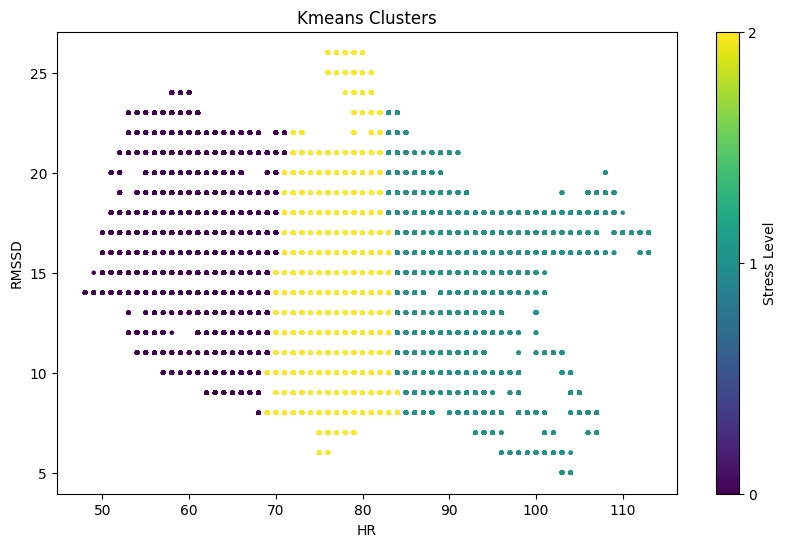

In [32]:
# Create Kmeans model with 3 clusters for the 3 classes [low, medium, high]
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data[['RMSSD', 'HR']])
data['stress_pred_kmeans'] = kmeans.predict(data[['RMSSD', 'HR']])

# Map the cluster labels to the stress levels
cluster_mapping = {0: 'low', 1: 'medium', 2: 'high'}
data['stress_pred_kmeans'] = data['stress_pred_kmeans'].map(cluster_mapping)

# Get the predictions of the Kmeans model and encode the labels to get the accuracy of this approach
labels_predictions = data['stress_pred_kmeans']

print('Kmeans Accuracy:', accuracy_score(labels, labels_predictions))
print('The classification report matrix of the Kmeans model is:\n', classification_report(labels, labels_predictions, zero_division=0))


# Plot the clusters
plt.figure(figsize=(10, 6))
plt.title('Kmeans Clusters')
plt.scatter(data['HR'], data['RMSSD'], c=data['stress_pred_kmeans'].map({'low': 0, 'medium': 1, 'high': 2}), s=5)
plt.xlabel('HR')
plt.ylabel('RMSSD')
plt.colorbar(ticks=[0, 1, 2], label='Stress Level')
plt.show()

## Machine Learning Approach (Random Forest)

In [33]:
# Get the features and labels for the Random Forest Classifier
X = data[['HR', 'RMSSD']]
y = data['condition']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Create the Random Forest Classifier model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Get the predictions of the Random Forest Classifier
data['stress_pred_rf'] = clf.predict(X)
labels_predictions = data['stress_pred_rf']

print('The classification report matrix of the train data for the Random Forest Classifier is:\n', classification_report(labels, labels_predictions, zero_division=0))

The classification report matrix of the train data for the Random Forest Classifier is:
               precision    recall  f1-score   support

        high       0.68      0.60      0.64     64057
         low       0.78      0.86      0.82    200082
      medium       0.73      0.65      0.69    105150

    accuracy                           0.76    369289
   macro avg       0.73      0.70      0.72    369289
weighted avg       0.75      0.76      0.75    369289



## Deep Learning Approach

In [34]:
# Feature Engineering and Scaling
num_classes = 3
features = data[['HR', 'RMSSD']]
labels   = data['condition']

# Create the train/test split
features_train, features_test, labels_train, labels_test= train_test_split(features, labels, test_size=0.2,random_state=34)

In [35]:
# Create callback function for early stopping in case we have a decrease in accuracy
callback = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=True, mode='auto', baseline=None, restore_best_weights=True)

# Define a small learning rate for the optimizer
optimizer = keras.optimizers.Adam(0.001)


# Create the Deep Learning Model Architecture
model = Sequential()
model.add(Input(shape=(features_train.shape[1],)))
model.add(Dense(features_train.shape[1], activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(3,activation='softmax'))

# Compilation of the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85 (340.00 B)

 Trainable params: 85 (340.00 B)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Encode the labels into numerical values
label_mapping = {'low': 0, 'medium': 1, 'high': 2}
labels_train_encoded = labels_train.map(label_mapping)
labels_test_encoded = labels_test.map(label_mapping)

# Train the model
history = model.fit(features_train, labels_train_encoded, validation_split=0.1, epochs=10, verbose=True, batch_size=256, callbacks=callback)

Epoch 1/10
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5734 - loss: 1.3031 - val_accuracy: 0.5914 - val_loss: 0.9398
Epoch 2/10
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5944 - loss: 0.9362 - val_accuracy: 0.5946 - val_loss: 0.9356
Epoch 3/10
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5931 - loss: 0.9334 - val_accuracy: 0.5736 - val_loss: 0.9386
Epoch 4/10
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5951 - loss: 0.9287 - val_accuracy: 0.5948 - val_loss: 0.9288
Epoch 5/10
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5975 - loss: 0.9250 - val_accuracy: 0.5906 - val_loss: 0.9275
Epoch 6/10
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5987 - loss: 0.9223 - val_accuracy: 0.6023 - val_loss: 0.9208
Epoch 7/10
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6044 - loss: 0.9181 - val_accuracy: 0.5995 - val_loss: 0.9205
Epoch 8/10
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6043 - loss: 0.9169 -

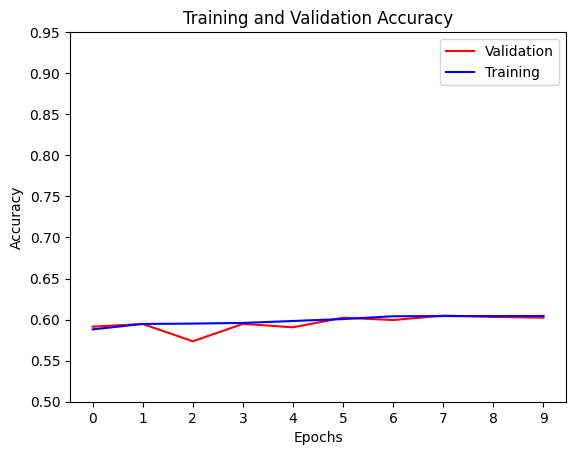

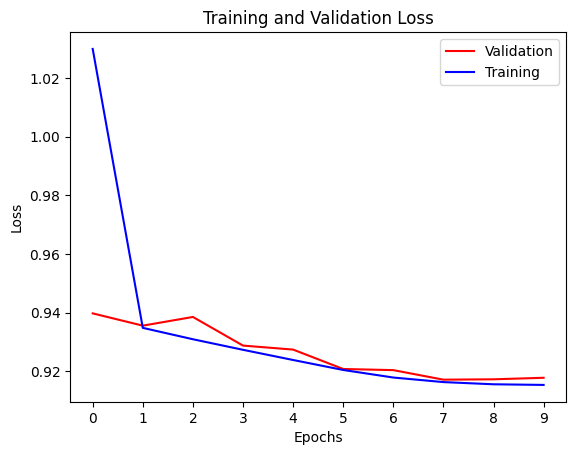

In [37]:
#Training Visualization
plt.plot(history.history['val_accuracy'],color='red',label='Validation')
plt.plot(history.history['accuracy'],color='blue',label='Training')
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.arange(0.5, 1, 0.05))
plt.xlabel('Epochs')    
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['val_loss'],color='red',label='Validation')
plt.plot(history.history['loss'],color='blue',label='Training')
plt.xticks(np.arange(0, 10, 1))
plt.xlabel('Epochs')    
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()